In [17]:
import time
import fasttext
from io import StringIO
import csv
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

<h2>FastText IMDB Model</h2>

In [31]:
imdb_path = "C:/Users/maddo/CS770_data/project_data/imdb_data"

In [32]:
# open fasttext-formatted corpus file
with open(imdb_path + "/fasttext_imdb_corpus.txt", "r", encoding="utf-8") as f:
    content = f.read()
    
# get content of corpus as a dataframe
# saving corpus to a text file and then splitting it later (in this file) allows for different random splits to be made if desired
content = content.replace("|||", '').replace("__label__positive", "__label__positive|||").replace("__label__negative", "__label__negative|||")
df = pd.read_csv(StringIO(content), delimiter="\|\|\|\s*", header=None, names=['sentiment', 'review'], quoting=3, engine='python')

In [33]:
# split data into predictor (review) and sentiment to be predicted
X = df['review']
y = df['sentiment']

# divide dataset into train, test, and validation sets (70, 20, 10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_tune, y_test, y_tune = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

# create list of dataframes to iterate through later
sets = []
setnames = ['train', 'test', 'tune']

train = y_train.to_frame().join(X_train) # create training set
sets.append(train)

test = y_test.to_frame().join(X_test) # create testing set
sets.append(test)

tune = y_tune.to_frame().join(X_tune) # create validation set
sets.append(tune)

In [34]:
i = 0
for set in sets:
    # write set contents to file
    set.to_csv(f"{imdb_path}/fasttext_{setnames[i]}_temp.txt", index=False, sep=" ", header=False, escapechar=" ", quoting=csv.QUOTE_NONE)
    
    with open(f"{imdb_path}/fasttext_{setnames[i]}_temp.txt", "r", encoding="utf-8") as f:
        lines = f.readlines() # read set contents from file
    
    cleaned_lines = []
    for line in lines:
        line = line.replace("  ", " ") # clean space padding
        cleaned_lines.append(line)

    # write fully cleaned set to file for fasttext to use
    if setnames[i] == 'tune':
        with open(f"{imdb_path}/fasttext_{setnames[i]}.valid", "w", encoding="utf-8") as f:
            f.writelines(cleaned_lines)
    else:
        with open(f"{imdb_path}/fasttext_{setnames[i]}.txt", "w", encoding="utf-8") as f:
            f.writelines(cleaned_lines)
    
    i += 1

In [3]:
times = [] # initialize list of times taken to train and tune the models

In [4]:
# record start time of training and predicting model
start_time = time.perf_counter()

# train model and tune on 10% validation set
imdb_model = fasttext.train_supervised(imdb_path + '/fasttext_train.txt', autotuneValidationFile=imdb_path + "/fasttext_tune.valid")

# save total time taken to list of times
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Time taken to train and tune imdb model:")
print(elapsed_time)
times.append(elapsed_time)

imdb_model.save_model(imdb_path + "/fasttext_imdb_model.bin") # save model so it can be referenced later

Time taken to trian and tune imdb model:
358.4954667000002


NameError: name 'model' is not defined

In [35]:
imdb_model = fasttext.load_model(imdb_path + "/fasttext_imdb_model.bin") # load the previously created model

result = imdb_model.test(imdb_path + "/fasttext_test.txt") # use built-in test function to get precision, recall
print("Manually-Calculated Model F1 Score:")
print((2 * result[1] * result[2]) / (result[1] + result[2])) # calculate F1 score from built-in test

# loop through each of the model's predictions in order to get confusion matrix and classification report
true_labels = []
texts = []
with open(imdb_path + "/fasttext_test.txt", "r", encoding="utf-8") as f:
    for line in f:
        label, text = line.split(" ", 1) # split at space after __label__sentiment
        true_labels.append(label.strip())
        texts.append(text.strip())
        
predicted_labels = [imdb_model.predict(text)[0][0] for text in texts] # predict each entry in the data


# print confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__positive", "__label__negative"])
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["positive", "negative"]))

Manually-Calculated Model F1 Score:
0.8995502248875562

Confusion Matrix:
[[4523  480]
 [ 525 4477]]

Classification Report:
              precision    recall  f1-score   support

    positive       0.90      0.90      0.90      5002
    negative       0.90      0.90      0.90      5003

    accuracy                           0.90     10005
   macro avg       0.90      0.90      0.90     10005
weighted avg       0.90      0.90      0.90     10005



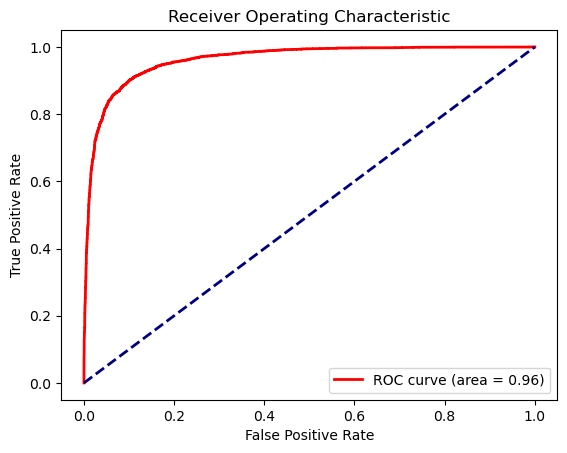

In [36]:
# print the roc-auc curve of the model
# do this by iterating through each data point and noting the positive probability of each prediction

true_labels = []  # List of true labels
predicted_probs = []  # List of predicted probabilities for the positive class

# Read the test data and predict probabilities
with open(imdb_path + "/fasttext_test.txt", "r", encoding="utf-8") as f:
    for line in f:
        label, text = line.split(" ", 1)
        true_labels.append(label.strip())

        # Get probabilities for both classes
        predictions, probabilities = imdb_model.predict(text.strip(), k=2)

        # Save the probability of the positive class
        prob_positive = probabilities[predictions.index("__label__positive")]
        predicted_probs.append(prob_positive)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs, pos_label="__label__positive")
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<h2>FastText Yelp Polarity Model</h2>

In [ ]:
yelp_path = "C:/Users/maddo/CS770_data/project_data/yelp_data"

In [23]:
# open fasttext-formatted corpus file
with open(yelp_path + "/fasttext_yelp_corpus.txt", "r", encoding="utf-8") as f:
    content = f.read()
    
# get content of corpus as a dataframe
# saving corpus to a text file and then splitting it later (in this file) allows for different random splits to be made if desired
content = content.replace("|||", '').replace("__label__positive", "__label__positive|||").replace("__label__negative", "__label__negative|||")
df = pd.read_csv(StringIO(content), delimiter="\|\|\|\s*", header=None, names=['sentiment', 'review'], quoting=3, engine='python')

In [24]:
# split data into predictor (review) and sentiment to be predicted
X = df['review']
y = df['sentiment']

# divide dataset into train, test, and validation sets (70, 20, 10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_tune, y_test, y_tune = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

# create list of dataframes to iterate through later
sets = []
setnames = ['train', 'test', 'tune']

train = y_train.to_frame().join(X_train) # create training set
sets.append(train)

test = y_test.to_frame().join(X_test) # create testing set
sets.append(test)

tune = y_tune.to_frame().join(X_tune) # create validation set
sets.append(tune)

In [25]:
i = 0
for set in sets:
    # write set contents to file
    set.to_csv(f"{yelp_path}/fasttext_{setnames[i]}_temp.txt", index=False, sep=" ", header=False, escapechar=" ", quoting=csv.QUOTE_NONE)
    
    with open(f"{yelp_path}/fasttext_{setnames[i]}_temp.txt", "r", encoding="utf-8") as f:
        lines = f.readlines() # read set contents from file
    
    cleaned_lines = []
    for line in lines:
        line = line.replace("  ", " ") # clean space padding
        cleaned_lines.append(line)

    # write fully cleaned set to file for fasttext to use
    if setnames[i] == 'tune':
        with open(f"{yelp_path}/fasttext_{setnames[i]}.valid", "w", encoding="utf-8") as f:
            f.writelines(cleaned_lines)
    else:
        with open(f"{yelp_path}/fasttext_{setnames[i]}.txt", "w", encoding="utf-8") as f:
            f.writelines(cleaned_lines)
    
    i += 1

In [26]:
# record start time of training and predicting model
start_time = time.perf_counter()

# train model and tune on 10% validation set
yelp_model = fasttext.train_supervised(yelp_path + '/fasttext_train.txt', autotuneValidationFile=yelp_path + '/fasttext_tune.valid')

# save total time taken to list of times
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Time taken to train and tune yelp model:")
print(elapsed_time)
times.append(elapsed_time)

yelp_model.save_model(yelp_path + "/fasttext_yelp_model.bin") # save model so it can be referenced later

Time taken to train and tune yelp model:
409.0782589999999


In [27]:
yelp_model = fasttext.load_model(yelp_path + "/fasttext_yelp_model.bin") # load the previously created model

result = yelp_model.test(yelp_path + "/fasttext_test.txt") # use built-in test function to get precision, recall
print("Manually-Calculated Model F1 Score:")
print((2 * result[1] * result[2]) / (result[1] + result[2])) # calculate F1 score from built-in test

# loop through each of the model's predictions in order to get confusion matrix and classification report
true_labels = []
texts = []
with open(yelp_path + "/fasttext_test.txt", "r", encoding="utf-8") as f:
    for line in f:
        label, text = line.split(" ", 1) # split at space after __label__sentiment
        true_labels.append(label.strip())
        texts.append(text.strip())
        
predicted_labels = [yelp_model.predict(text)[0][0] for text in texts] # predict each entry in the data


# print confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__positive", "__label__negative"])
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["positive", "negative"]))

Manually-Calculated Model F1 Score:
0.94484007996002

Confusion Matrix:
[[52857  3171]
 [ 3010 53018]]

Classification Report:
              precision    recall  f1-score   support

    positive       0.94      0.95      0.94     56028
    negative       0.95      0.94      0.94     56028

    accuracy                           0.94    112056
   macro avg       0.94      0.94      0.94    112056
weighted avg       0.94      0.94      0.94    112056



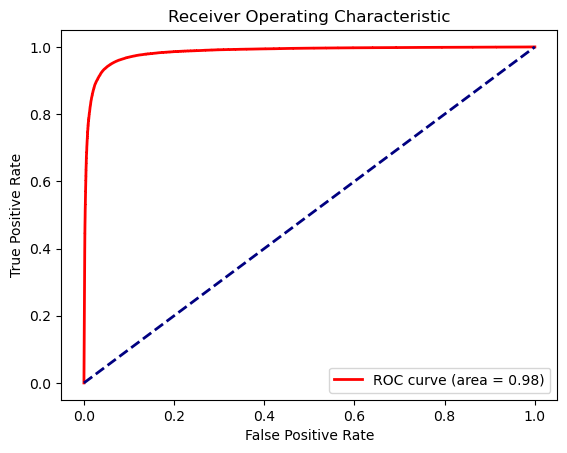

In [28]:
# print the roc-auc curve of the model
# do this by iterating through each data point and noting the positive probability of each prediction

true_labels = []  # List of true labels
predicted_probs = []  # List of predicted probabilities for the positive class

# Read the test data and predict probabilities
with open(yelp_path + "/fasttext_test.txt", "r", encoding="utf-8") as f:
    for line in f:
        label, text = line.split(" ", 1)
        true_labels.append(label.strip())

        # Get probabilities for both classes
        predictions, probabilities = yelp_model.predict(text.strip(), k=2)

        # Save the probability of the positive class
        prob_positive = probabilities[predictions.index("__label__positive")]
        predicted_probs.append(prob_positive)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs, pos_label="__label__positive")
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()